## Load libraries

In [1]:
library(ggplot2)
library(dplyr)
library(reshape)
library(reshape2)
library(ComplexHeatmap)
library(circlize)
library(RColorBrewer)
library(ggrastr)
library(tidyverse)
library(data.table)
library(Signac)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(org.Hs.eg.db)
library(ChIPseeker)
library(repr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into a

## Set paths to reference files

In [2]:
#Color scale for cancer types
cols=readRDS('../data/Colors_panatac_v2.0.rds')
dis_cols_ed=cols$Cancer

#Color scale for tissue types
tiss_cols=c("Tumor"="#377EB8","Normal"="#4DAF4A","Met"="#E41A1C")

#List of cancer related genes
c_genes=read.table('../data/Gene_lists/624_Cancer_genes.txt',sep='\t',header=F)

#Path to catalog
cat=read_delim('../data/ATAC_catalog.20220114.v2.txt',delim='\t',show_col_types = FALSE)
cat=as.data.frame(cat)

#Metastasis associated DEGs
all_degs=read.table('../data/snRNA/Table_S6b_Met_DEGs.txt',sep='\t',header=T)

#Metastasis associated DACRs
all_dacrs=read.table('../data/snATAC/Table_S6a_Met_DACRs.txt',sep='\t',header=T)
all_dacrs=all_dacrs[all_dacrs$p_val_adj<0.05 & all_dacrs$avg_log2FC>0,]

#Matrix with accessibility averaged per tumor cells from each sample, and per normal cells from tissue
path_to_ATAC_average_matrix='../data/snATAC/Average_accessibility_matrix.DataSlot.20230212.tsv'

#Cell counts per each cell group in matrix with average ATAC accessibility
path_to_ATAC_average_matrix_meta='../data/snATAC/Cell_count_perGroup.forAverageAccessibilityMatrix.20230212.tsv'

#Sample level fold changes
fch=NULL
cancers=c('PDAC','CRC','UCEC','SKCM')
for (can in cancers){
tab_fch=fread(paste('../data/snATAC/Met_vs_primary_fold_change/Fch_peaks_Met_primary_SampleLevel.',can,'.20230330.tsv',sep=''))
tab_fch=as.data.frame(tab_fch)
fch=rbind(fch,tab_fch)
}
fch=fch[,c(1,4:6)]

In [3]:
#Format catalog
colnames(cat)=gsub(' ','_',colnames(cat))

cat$Piece_ID=paste(cat$Disease_Type,cat$Piece_ID,sep='_')
cat=cat %>% dplyr::select ('Piece_ID','Sample_Type')
colnames(cat)[2]=c('Sample_type')

In [4]:
#Read average accessibility matrix
tab_1=fread(path_to_ATAC_average_matrix)
tab_1=as.data.frame(tab_1)
rownames(tab_1)=tab_1[,1]
tab_1=tab_1[,-1]
tab_1=tab_1[,grepl('^Tumor_',colnames(tab_1))]
tab=tab_1

Warning message in fread(path_to_ATAC_average_matrix):
“Detected 245 column names but the data has 246 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [5]:
#Remove cell groups with cells n <20
meta=read.table(path_to_ATAC_average_matrix_meta,sep='\t',header=T)
meta_s=meta[meta$Cell_count>=20,]
colnames(tab)=gsub('\\.','-',colnames(tab))

tab=t(tab)
tab=tab[rownames(tab) %in% meta_s$Cell_type,]

In [6]:
row_annot=as.data.frame(rownames(tab))
colnames(row_annot)='ID'
row_annot$Cell_type=gsub('(.*)__(.*)_(.*)','\\1',row_annot$ID)
row_annot$Disease=gsub('(.*)__(.*)_(.*)','\\2',row_annot$ID)
row_annot$Piece_ID=gsub('Tumor__','',row_annot$ID)
row_annot$Disease=gsub('(.*)_.*','\\1',row_annot$Disease)
row_annot$Disease=ifelse(row_annot$Piece_ID %in% paste('BRCA',c("HT029B1-S1PC","HT035B1-S1PA","HT141B1-S1H1","HT206B1-S1H4","HT1408-06","HT268B1-Th1H3","HT271B1-S1H3","HT378B1-S1H1", "HT378B1-S1H2", "HT384B1-S1H1", "HT517B1-S1H1"),sep='_'),'BRCA_Basal',row_annot$Disease)
row_annot$Disease=ifelse(row_annot$Disease=='PKD','ccRCC',row_annot$Disease)
row_annot=row_annot[row_annot$Disease %in% c('CRC','PDAC','SKCM','UCEC'),]
row_annot$Cell_type=ifelse(row_annot$Cell_type=='Tumor_OV','Tumor',row_annot$Cell_type)
row_annot$ID_2=paste(row_annot$Disease,row_annot$Cell_type,sep='_')
rownames(row_annot)=row_annot$ID

row_annot=merge(row_annot, cat,all.x=T)
rownames(row_annot)=row_annot$ID

In [7]:
tab=tab[rownames(row_annot),]
to_plot=scale(tab)

test_up=all_dacrs
colnames(test_up)[1]='Disease'
st_up=as.data.frame(table(test_up$peak))

#Keep only specific to one cancer type peaks
test_up_1=test_up[test_up$peak %in% st_up$Var1[st_up$Freq==1],]
rownames(test_up_1)=test_up_1$peak

In [8]:
up_peaks=test_up_1
up_peaks=up_peaks[,c(1,2)]

#Add sample level fold changes
res=merge(up_peaks,fch,all.x=T)

In [9]:
#Keep top 200 DACRs by number of samples with UP fold change, and then by mean fold change
all_res=NULL
for (can in c('CRC','PDAC','SKCM','UCEC')){
    res_s=res[res$Disease==can,]
    res_1=reshape2::dcast(data=res_s,peak~Piece_ID,value.var='avg_log2FC')
    rownames(res_1)=res_1[,1]
    res_1=res_1[,-1]
    res_1$Count_up=apply(res_1,1, function(x) length(x[!is.na(x) & x>0]))
    res_1$Mean=apply(res_1[,1:(ncol(res_1)-1)],1, function(x) mean(x,na.rm=T))
    n_samples=ncol(res_1)-2
    res_1$Fraction=res_1$Count_up/n_samples
    res_1_s=res_1[res_1$Fraction>=0.5 & res_1$Mean>0,]
    res_1_s=res_1_s[order(-res_1_s$Mean),]
    res_1_s=res_1_s[order(-res_1_s$Count_up),]
    res_1_s=res_1_s[1:200,]
    if (nrow(res_1_s)>0){
    res_1_s=res_1_s[,c('Count_up','Mean','Fraction')]
    res_1_s$peak=rownames(res_1_s)
    res_1_s$Disease=can
    all_res=rbind(all_res,res_1_s)
}
}
all_res=all_res[!is.na(all_res$peak),]

In [10]:
annot=row_annot

annot$Dis_ID=1
annot$Dis_ID=ifelse(annot$Disease=='CRC',1,annot$Dis_ID)
annot$Dis_ID=ifelse(annot$Disease=='PDAC',2,annot$Dis_ID)
annot$Dis_ID=ifelse(annot$Disease=='SKCM',3,annot$Dis_ID)
annot$Dis_ID=ifelse(annot$Disease=='UCEC',4,annot$Dis_ID)
annot=annot[order(annot$Sample_type),]
annot=annot[order(annot$Dis_ID),]

tab=to_plot
tab=tab[rownames(annot),colnames(tab) %in% all_res$peak]

In [11]:
#Annotate peaks with the closest gene
peaks_1=StringToGRanges(colnames(tab), sep = c("-", "-"))

peakAnno <- annotatePeak(peaks_1, tssRegion=c(-1000, 100),
                         TxDb=TxDb.Hsapiens.UCSC.hg38.knownGene, annoDb="org.Hs.eg.db")
                         
anno=as.data.frame(peakAnno)
peaks=as.data.frame(colnames(tab))
colnames(peaks)='peak'
peaks$Gene=anno$SYMBOL
peaks$Type=anno$annotation

peaks$annot=peaks$Gene
peaks=merge(peaks,all_res,all.x=T)

>> preparing features information...		 2023-09-06 13:49:16 
>> identifying nearest features...		 2023-09-06 13:49:17 
>> calculating distance from peak to TSS...	 2023-09-06 13:49:17 
>> assigning genomic annotation...		 2023-09-06 13:49:17 
>> adding gene annotation...			 2023-09-06 13:49:31 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2023-09-06 13:49:31 
>> done...					 2023-09-06 13:49:31 


In [12]:
#Add DEGs info
peaks_pr=peaks
peaks_pr=peaks_pr[!duplicated(peaks_pr[,c('Disease','Gene')]),]
peaks_pr=peaks_pr[,c('peak','Type','Disease','Gene')]

degs=all_degs
colnames(degs)[6]='Disease'
degs=merge(peaks_pr,degs)

degs=degs[order(-degs$avg_log2FC),]
degs=degs[degs$avg_log2FC>0,]

In [13]:
#Annotate top 15 by fold change DEGs and LAMA5
top_degs=NULL
for (can in c('CRC','PDAC','SKCM','UCEC')){
    degs_s=degs[degs$Disease==can,]
    degs_s=degs_s[!grepl('^LINC|^MIR|^RPS|^RPL|\\.1',degs_s$Gene),]
    top_degs=rbind(top_degs,degs_s[1:15,])
}
top_degs=as.data.frame(top_degs)
peaks$annot_v2=ifelse(peaks$peak %in% c(top_degs$peak, peaks$peak[peaks$Gene=='LAMA5']),peaks$Gene,'')

In [14]:
col_annot=as.data.frame(colnames(tab))
colnames(col_annot)[1]='peak'
col_annot=merge(col_annot,all_res,all.x=T)

tab=tab[rownames(annot),col_annot$peak]
rownames(peaks)=peaks$peak
peaks=peaks[col_annot$peak,]

## Do plotting with ComplexHeatmap

In [15]:
annot_mark=colnames(tab) %in% peaks$peak[peaks$annot_v2!=""]

column_ha=HeatmapAnnotation(link = anno_mark(at = which(annot_mark), labels = peaks$Gene[peaks$annot_v2!=""],
                                             labels_gp = gpar(fontsize = 14),side='bottom'))
row_ha=rowAnnotation(Sample_type=annot$Sample_type,Disease=annot$Disease,
                     col=list(Disease=dis_cols_ed,Sample_type=tiss_cols))

In [16]:
x=Heatmap(tab,bottom_annotation=column_ha,
          col= colorRamp2(c(-1.5, 0, 1.5), c("#377EB8", "white", "#E41A1C")),
          right_annotation=row_ha,show_row_names = F,show_column_names = FALSE,
          show_row_dend=FALSE,show_column_dend=FALSE,name='Peak_accessibility', 
          cluster_rows=F, use_raster=T,
          column_split=factor(col_annot$Disease,levels=c('CRC','PDAC','SKCM','UCEC')),
          cluster_columns=F, row_split=factor(row_annot$Disease,levels=c('CRC','PDAC','SKCM','UCEC')))

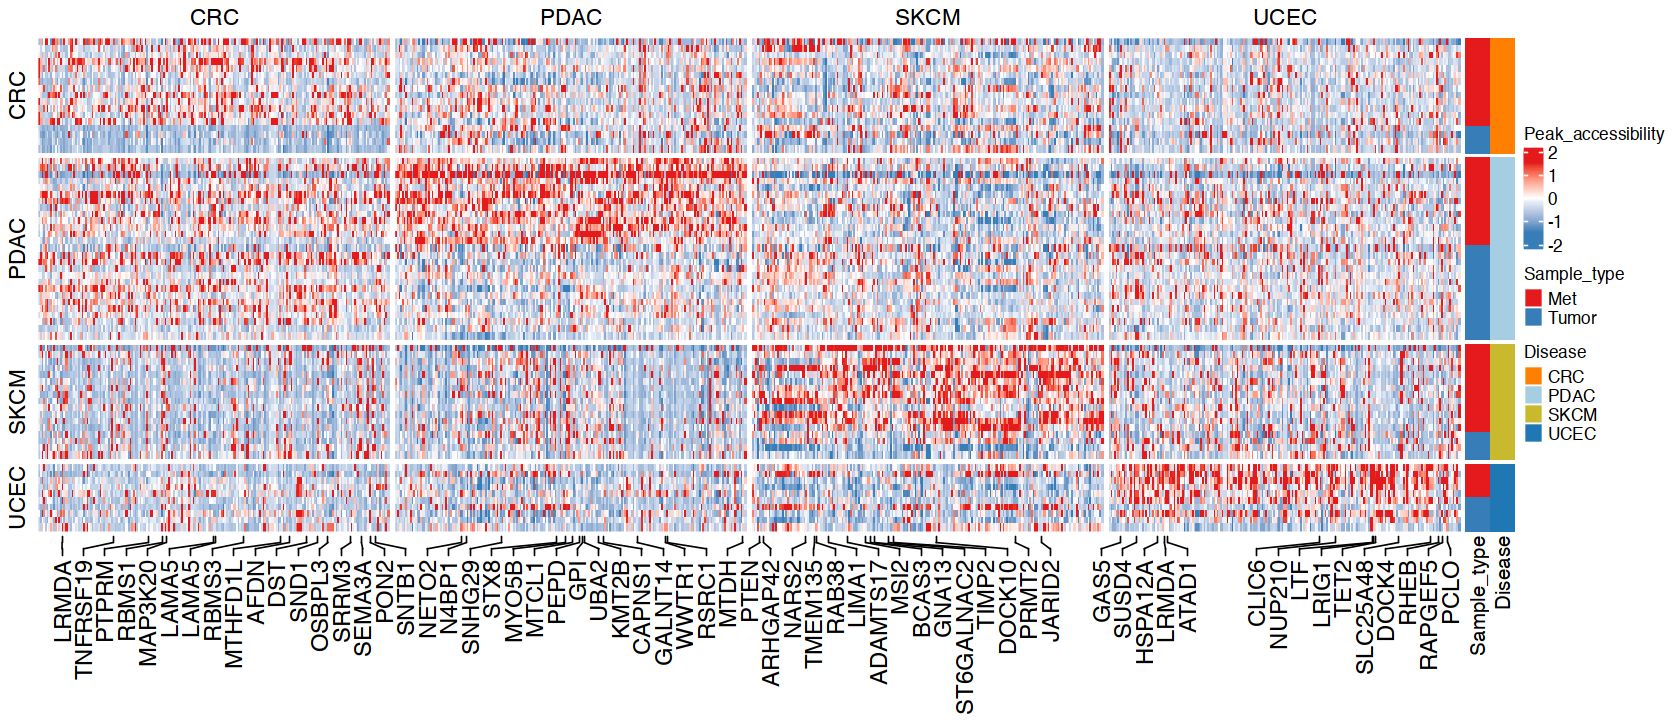

In [ ]:
options(repr.plot.width=14, repr.plot.height=6)
x